In [1]:
import pandas as pd
from traffic.core import Traffic
from traffic.data import opensky
from traffic.data import airports
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import datetime
import importlib


In [3]:
start = "2024-06-01 00:00"
stop = "2024-06-02 23:59"
airport_str = 'LSZH'

timestamps = pd.date_range(start, stop, freq="4h")
data = []
for t1, t2 in tqdm(zip(timestamps[:-1], timestamps[1:]), total=len(timestamps) - 1, desc="Processing timestamps"):
#for t1, t2 in zip(timestamps[:-1], timestamps[1:]):
        tmp = opensky.history(start=str(t1), stop=str(t2), bounds=airports[airport_str].shape.convex_hull.buffer(0.1))
        if tmp is not None:
            data.append(tmp.data)
        

trajs = pd.concat(data)
trajs = Traffic(trajs)

Matplotlib is building the font cache; this may take a moment.


In [5]:
# Reduce to lat/lon & altitude of interest
gnd_trajs = trajs.query('altitude<4000 or onground')

# Add aircraft information
gnd_trajs = gnd_trajs.aircraft_data()

# Resample & cumulative distance
gnd_trajs = gnd_trajs.assign_id().resample('1s').eval(max_workers=8, desc='resampling')
gnd_trajs = gnd_trajs.cumulative_distance().eval(max_workers=8, desc='cumdist')


*** 
# Runway and Pushback classification
***

In [244]:
import agps_funs
importlib.reload(agps_funs)
from agps_funs import alternative_pushback_detection, takeoff_detection
from agps_config import get_Stands_LSZH

# Runway classification
gnd_trajs = gnd_trajs.iterate_lazy().pipe(takeoff_detection, 'lszh').eval(max_workers=8, desc='Takeoff Detection')

# Pushback classification
stands = get_Stands_LSZH()
gnd_trajs = gnd_trajs.iterate_lazy().pipe(alternative_pushback_detection, stands).eval(max_workers=8, desc='Pushback Detection')

In [246]:
# Pickle (if required)
gnd_trajs.to_pickle(airport_str+'_pushbackplot.pkl')

***
# Finding nice pushbacks
***

Nice pushback trajectories:

* 'UAL45_1948'
* 'QTR52W_013'
* 'SWR146_905'
* 'THA971_1930'
* 'EDW58T_988'
* 'THY6LF_1677'
* 'BAW709_189'

In [269]:
# Finding flight_id of flights performing pushback

pushback_ids = gnd_trajs.query('isTakeoff and (isPushback)').data['flight_id'].unique()

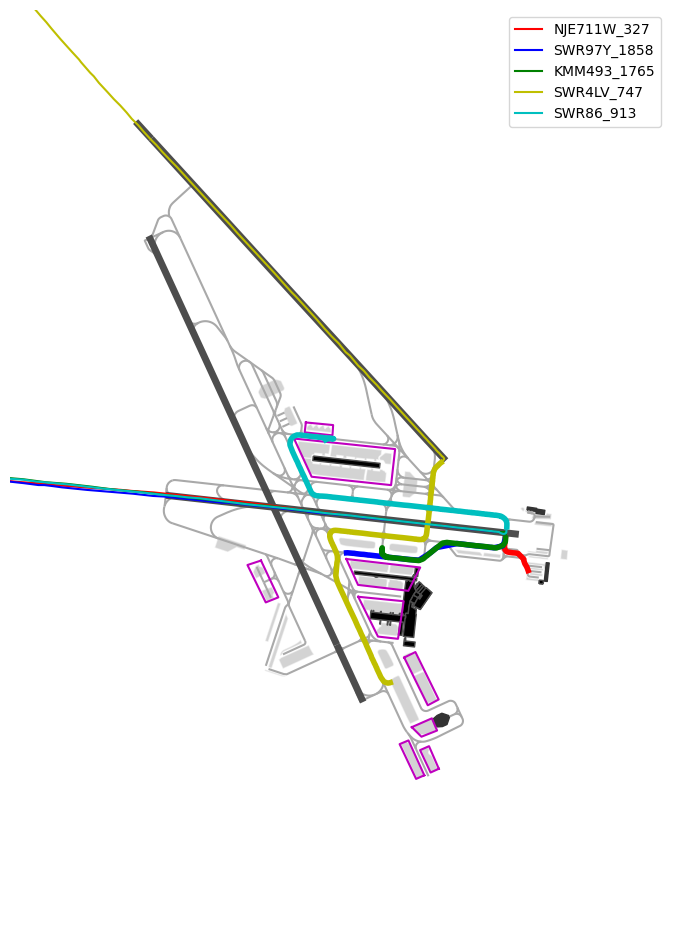

In [280]:
# Visual inspection of randomly selected pushback flights

from cartes.crs import EuroPP
import cartopy.crs as ccrs
data_proj = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=EuroPP()))
airports[airport_str].plot(ax, by='aeroway', aerodrome=dict(alpha=0))
ax.spines["geo"].set_visible(False)
ax.set_extent((8.5230, 8.5855, 47.4904, 47.4306))

for stand in stands:
    ax.plot(*stand.exterior.xy, transform=data_proj, color = 'm')


colors = ['r', 'b', 'g', 'y', 'c']
sample_ids = np.random.choice(pushback_ids, size=5, replace=False)

# Plot the trajectories
for i, id in enumerate(sample_ids):
    
    # Plot the entire trajectory
    gnd_trajs[id].plot(ax=ax, color=colors[i], label=f'{gnd_trajs[id].data.flight_id.iloc[0]}')

    # Highlight taxi part
    gnd_trajs[id].between(gnd_trajs[id].data.startTaxi.iloc[0], gnd_trajs[id].data.lineupTime.iloc[0]).plot(ax=ax, color=colors[i], linewidth=4)

    # Highlight pushback
    if gnd_trajs[id].data.isPushback.iloc[0]:
        gnd_trajs[id].between(gnd_trajs[id].data.startPushback.iloc[0], gnd_trajs[id].data.startTaxi.iloc[0]).plot(ax=ax, color='m', linewidth=4)

plt.legend(loc='upper right')

plt.show()

***
# Plotting nice pushbacks for paper
***

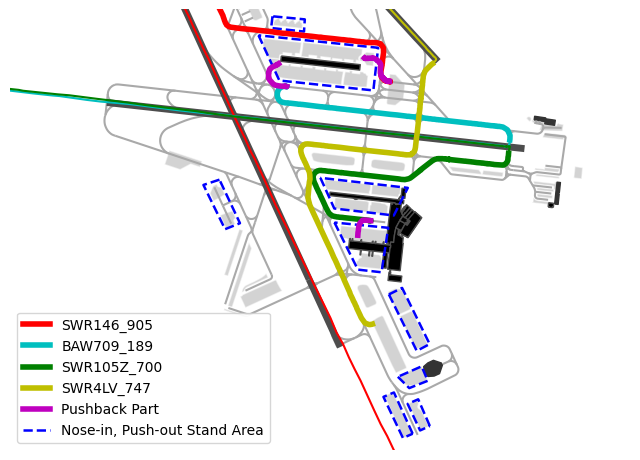

In [281]:
from cartes.crs import EuroPP
import cartopy.crs as ccrs
data_proj = ccrs.PlateCarree()


fig, ax = plt.subplots(1, 1, figsize=(8, 16), subplot_kw=dict(projection=EuroPP()))
airports[airport_str].plot(ax, by='aeroway', aerodrome=dict(alpha=0))
ax.spines["geo"].set_visible(False)
ax.set_extent((8.53, 8.58, 47.464, 47.44))


for stand in stands:
    ax.plot(*stand.exterior.xy, transform=data_proj, color = 'b', linestyle='--', linewidth=1.8)


colors = ['r', 'c', 'g', 'y', 'c']


sample_ids = ['SWR146_905', 'BAW709_189', 'SWR105Z_700', 'SWR4LV_747']

# Plot the trajectories
for i, id in enumerate(sample_ids):
    
    # Plot the entire trajectory
    gnd_trajs[id].plot(ax=ax, color=colors[i])

    # Highlight taxi part
    gnd_trajs[id].between(gnd_trajs[id].data.startTaxi.iloc[0], gnd_trajs[id].data.lineupTime.iloc[0]).plot(ax=ax, color=colors[i], linewidth=4, label=f'{gnd_trajs[id].data.flight_id.iloc[0]}')

    # Highlight pushback
    if gnd_trajs[id].data.isPushback.iloc[0]:
        gnd_trajs[id].between(gnd_trajs[id].data.startPushback.iloc[0], gnd_trajs[id].data.startTaxi.iloc[0]).plot(ax=ax, color='m', linewidth=4)

# Add labels for pushback and stands
ax.plot([], [], color='m', linewidth=4, label='Pushback Part')
ax.plot([], [], color='b', linewidth=1.8, linestyle='--', label='Nose-in, Push-out Stand Area')  # Cyan line for stands

plt.legend(loc='lower left')

plt.savefig('pushback_types.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

***
# Plot for Presentation
***

In [2]:
gnd_trajs = Traffic.from_file('LSZH_pushbackplot.pkl')
gnd_trajs

,count
flight_id,
ATL779_1390,31153
TE25_1541,27365
ATL778_1544,24827
ZEBRA1_1266,23095
SWR6PC_750,20031
ATL785_1457,16928
ATL781_1412,16716
ATL778_1546,16024
ATL779_1381,16021


In [5]:
gnd_trajs.data.flight_id

0        AAL92_1963
1        AAL92_1963
2        AAL92_1963
3        AAL92_1963
4        AAL92_1963
           ...     
2562    ZEBRA8_1295
2563    ZEBRA8_1295
2564    ZEBRA8_1295
2565    ZEBRA8_1295
2566    ZEBRA8_1295
Name: flight_id, Length: 2786875, dtype: object

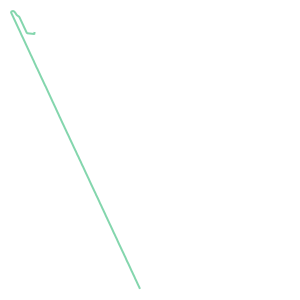

In [6]:
# gnd_trajs['SWR105Z_700']
gnd_trajs['AAL92_1963']


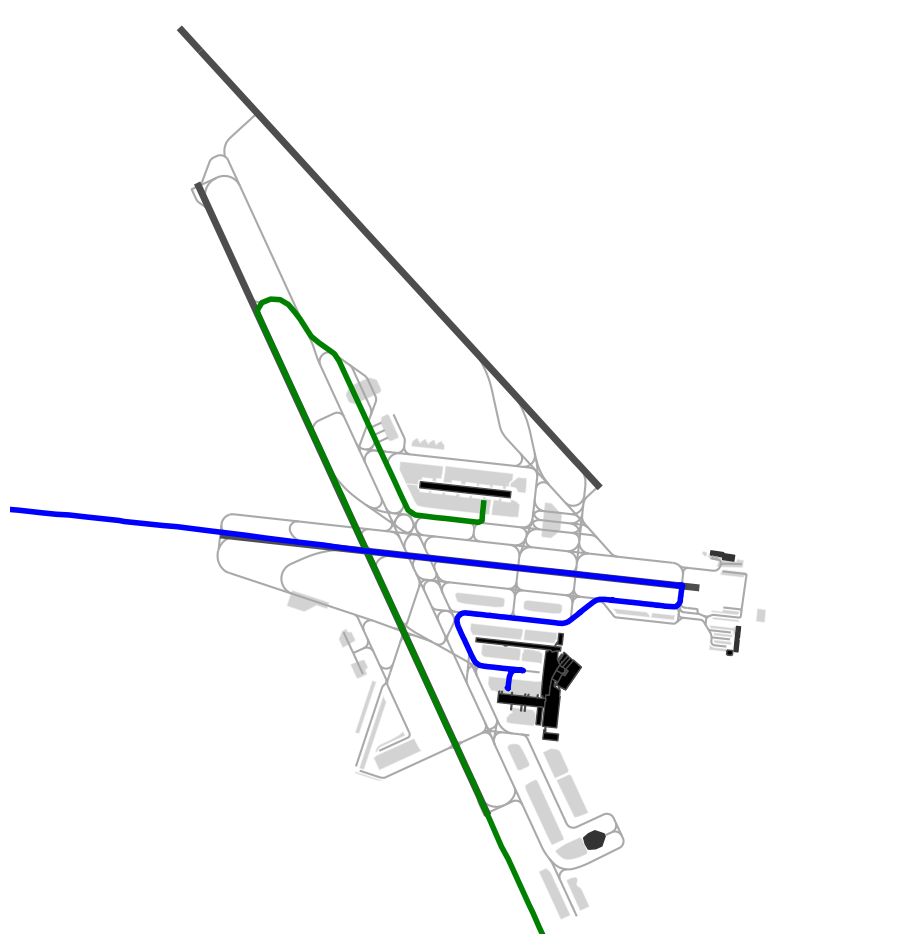

In [25]:
from cartes.crs import EuroPP
import cartopy.crs as ccrs
data_proj = ccrs.PlateCarree()

airport_str='LSZH'

fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=EuroPP()))
airports[airport_str].plot(ax, by='aeroway', aerodrome=dict(alpha=0))
ax.spines["geo"].set_visible(False)
ax.set_extent((8.5230, 8.5855, 47.484, 47.44))

colors = ['g', 'b']

sample_ids = ['AAL92_1963','SWR105Z_700']

for i, id in enumerate(sample_ids):
    gnd_trajs[id].plot(ax=ax, color=colors[i], linewidth=4, label=gnd_trajs[id].callsign)


# plt.legend(loc='upper right', fontsize=14)
plt.savefig('arrival_departure.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

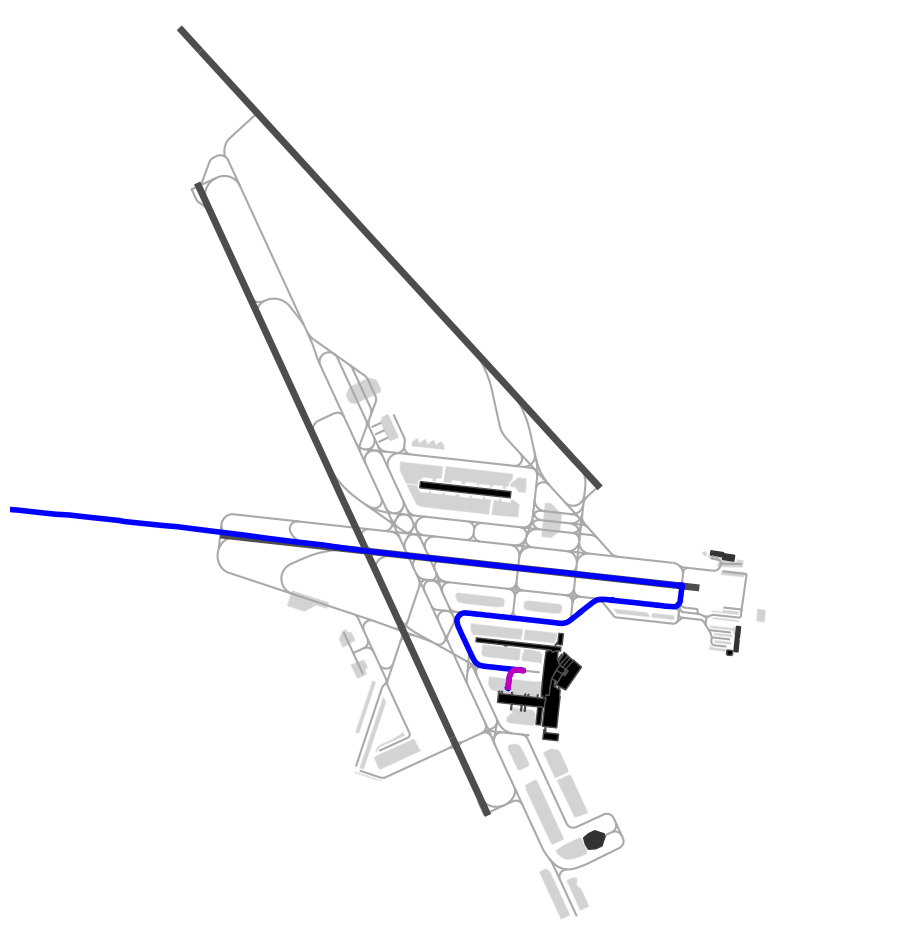

In [27]:
from cartes.crs import EuroPP
import cartopy.crs as ccrs
data_proj = ccrs.PlateCarree()

airport_str='LSZH'

fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=EuroPP()))
airports[airport_str].plot(ax, by='aeroway', aerodrome=dict(alpha=0))
ax.spines["geo"].set_visible(False)
ax.set_extent((8.5230, 8.5855, 47.484, 47.44))

colors = ['b']

sample_ids = ['SWR105Z_700']

for i, id in enumerate(sample_ids):
    gnd_trajs[id].plot(ax=ax, color=colors[i], linewidth=4, label=gnd_trajs[id].callsign)

    # Highlight pushback
    if gnd_trajs[id].data.isPushback.iloc[0]:
        gnd_trajs[id].between(gnd_trajs[id].data.startPushback.iloc[0], gnd_trajs[id].data.startTaxi.iloc[0]).plot(ax=ax, color='m', linewidth=4)


# plt.legend(loc='upper right', fontsize=14)
plt.savefig('departure.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()